### Classifying the data using CNN

### Steps to follow:

### 1. Importing the Libraries

In [27]:
from __future__ import absolute_import
from __future__ import print_function
from datetime import timedelta
import time
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 5.0) 


### 2. Loading the data

In [28]:
h5f = h5py.File('SVHN_gray.h5', 'r')

xTrain = h5f['X_train'][:]
yTrain = h5f['y_train'][:]
xTest = h5f['X_test'][:]
yTest = h5f['y_test'][:]
xVal = h5f['X_val'][:]
yVal = h5f['y_val'][:]

h5f.close()

print('Training set: ', xTrain.shape, yTrain.shape)
print('Validation set: ', xVal.shape, yVal.shape)
print('Test set: ', xTest.shape, yTest.shape)

Training set:  (62268, 32, 32, 1) (62268, 10)
Validation set:  (10989, 32, 32, 1) (10989, 10)
Test set:  (26032, 32, 32, 1) (26032, 10)


### 3. Plotting m rows x n columns

In [29]:
def plotImages(image, rows, cols, cls_true, cls_pred=None):
 
    fig, axes = plt.subplots(rows, cols)

    res = np.random.choice(image.shape[0], rows*cols)
    
    for i, j in zip(res, axes.flat): 
        
        
        if cls_pred is None:
            title = "True: {0}".format(np.argmax(cls_true[i]))
        
        else:
            title = "True: {0}, Pred: {1}".format(np.argmax(cls_true[i]), cls_pred[i])  
     
        j.imshow(image[i,:,:,0], cmap='binary')
        
    
        j.set_title(title)
        
        j.set_xticks([])
        j.set_yticks([])

### 4. Getting batch dynamically

In [30]:
def get_batch(X, y, batch_size=512):
    for i in np.arange(0, y.shape[0], batch_size):
        end = min(X.shape[0], i + batch_size)
        yield(X[i:end],y[i:end])

### 5. Using placeholder var whose value can be directly given to the graph

In [31]:
comp = 32*32

x = tf.placeholder(tf.float32, shape = [None, 32, 32, 1], name='Input_Data')
y = tf.placeholder(tf.float32, shape = [None, 10], name='Input_Labels')
yCls = tf.argmax(y, 1)

discard_rate = tf.placeholder(tf.float32, name='Discard_Rate')

### 6. Defining CNN Model

In [32]:
def cnn_model(features):
    
    input_layer = tf.reshape(features, [-1, 32, 32, 1], name='Reshaped_Input')

    
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)

    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    conv2 = tf.layers.conv2d(
          inputs=pool1,
          filters=64,
          kernel_size=[5, 5],
          padding="same",
          activation=tf.nn.relu)
        
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    pool2_flat = tf.reshape(pool2, [-1, 8 * 8 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=256, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
         inputs=dense, rate=discard_rate)
    logits = tf.layers.dense(inputs=dropout, units=10)

    return logits

In [33]:
max_epochs = 3
num_examples = xTrain.shape[0]

### 7. Predicting and optimizing the model

In [34]:
predict = cnn_model(x)
predictCls = tf.argmax(predict, 1)

loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(
   onehot_labels=y, logits=predict))
  
optimizer = tf.train.AdamOptimizer().minimize(loss)

### 8. Calculating the actual prediction and the accuracy

In [35]:
correctPrediction = tf.equal(predictCls, yCls)

accuracy = tf.reduce_mean(tf.cast(correctPrediction, tf.float32))

### 9. Starting the tensorflow session

In [36]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

### 10. Initializing the batch size and % of neurons to be discarded in the training mode

In [37]:
batch_size = 512

discardPercent = 0.7

In [38]:
trainLoss = []
validLoss = []
startTime = time.time()
print ('Training :')
for epoch in range(max_epochs):
    epochLoss = 0
    print()
    print ('Epoch ', epoch+1 , ': \n')
    step = 0   
    
    for (epoch_x , epoch_y) in get_batch(xTrain, yTrain, batch_size):
        _, train_accu, c = sess.run([optimizer, accuracy, loss], feed_dict={x: epoch_x, y: epoch_y, discard_rate: discardPercent})
        trainLoss.append(c)
    
        if(step%40 == 0):
            print ("Step:", step, " ")
            print('Batch Accuracy :' , train_accu*100.0, '%')
            
            accu = 0.0
            for (epoch_x , epoch_y) in get_batch(xVal, yVal, 512):                            
                correct, _c = sess.run([correctPrediction, loss], feed_dict={x: epoch_x, y: epoch_y, discard_rate: 0.0})
                validLoss.append(_c)
                accu+= np.sum(correct[correct == True])
            print('Validation Accuracy/Classification Result :' , accu*100.0/yVal.shape[0], '%')
            print ()
        step = step + 1


    print ('Epoch', epoch+1, 'out of ', max_epochs, 'completed!')

time_diff = time.time() - startTime

accu = 0.0
for (epoch_x , epoch_y) in get_batch(xTest, yTest, 512):
    correct = sess.run([correctPrediction], feed_dict={x: epoch_x, y: epoch_y, discard_rate: 0.0})
    accu+= np.sum(correct[correct == True])

print ()
print('Test Accuracy/Comparison Result : ' , accu*100.0/yTest.shape[0], '%')


Training :

Epoch  1 : 

Step: 0  
Batch Accuracy : 16.2109375 %
Validation Accuracy/Classification Result : 18.30921830921831 %

Step: 40  
Batch Accuracy : 68.5546875 %
Validation Accuracy/Classification Result : 70.97097097097097 %

Step: 80  
Batch Accuracy : 81.8359375 %
Validation Accuracy/Classification Result : 81.15388115388116 %

Step: 120  
Batch Accuracy : 85.3515625 %
Validation Accuracy/Classification Result : 84.73928473928474 %

Epoch 1 out of  3 completed!

Epoch  2 : 

Step: 0  
Batch Accuracy : 86.1328125 %
Validation Accuracy/Classification Result : 84.42078442078441 %

Step: 40  
Batch Accuracy : 88.4765625 %
Validation Accuracy/Classification Result : 84.96678496678497 %

Step: 80  
Batch Accuracy : 87.6953125 %
Validation Accuracy/Classification Result : 86.33178633178633 %

Step: 120  
Batch Accuracy : 87.6953125 %
Validation Accuracy/Classification Result : 86.86868686868686 %

Epoch 2 out of  3 completed!

Epoch  3 : 

Step: 0  
Batch Accuracy : 89.2578125 %
V

### 11. Plotting data

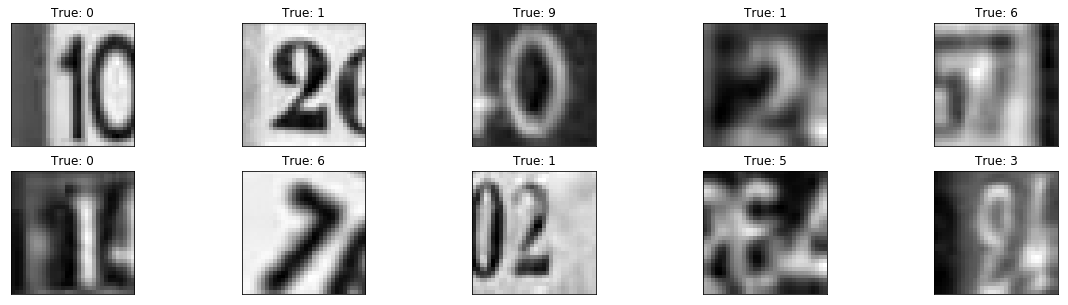

In [39]:
plotImages(xTrain, 2, 5, yTrain);

In [40]:
testPred = []
for (epoch_x , epoch_y) in get_batch(xTest, yTest, 512):
    correct = sess.run([predictCls], feed_dict={x: epoch_x, y: epoch_y, discard_rate: 0.0})
    testPred.append((np.asarray(correct, dtype=int)).T)

### 12. Converting lists to numpy array

In [41]:
def flatten(lists):
    result = []
    for numbers in lists:
        for x in numbers:
            result.append(x)
    return np.asarray(result)

flatArray = flatten(testPred)
flatArray = (flatArray.T)
flatArray = flatArray[0]

flatArray.shape

(26032,)

### 13. Plotting wrongly classified random images

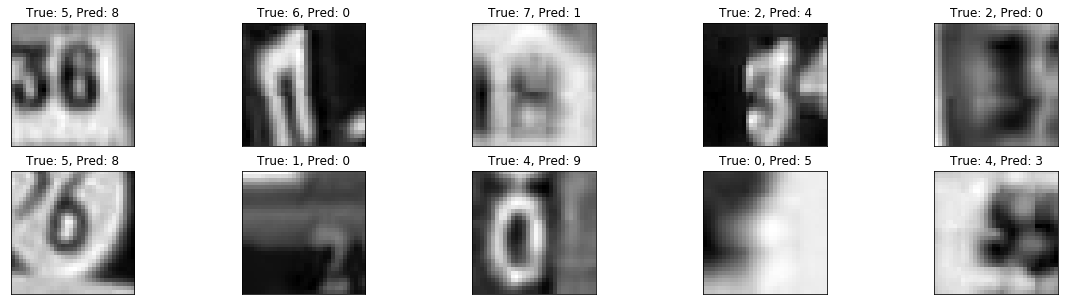

In [48]:
wrongPrediction = flatArray != np.argmax(yTest, axis=1)

images = xTest[wrongPrediction]
clsTrue = yTest[wrongPrediction]
clsPred = flatArray[wrongPrediction]

plotImages(images, 2, 5, clsTrue, clsPred);

### 14. Plotting correctly classified random images

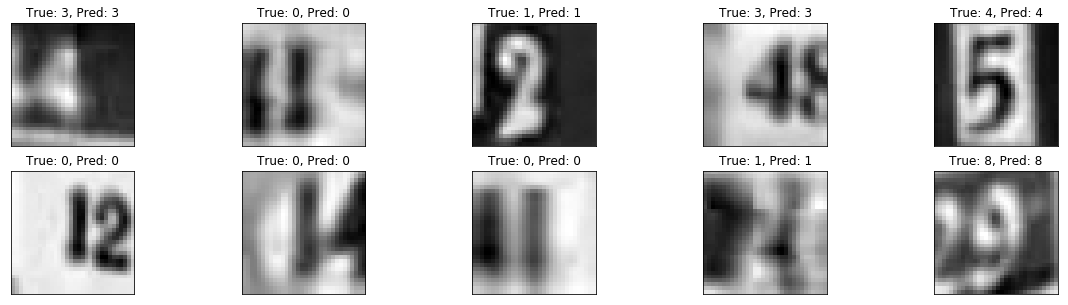

In [47]:
rightPrediction = np.invert(wrongPrediction)

images = xTest[rightPrediction]
clsTrue = yTest[rightPrediction]
clsPred = flatArray[rightPrediction]

plotImages(images, 2, 5, clsTrue, clsPred);